In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#!pip install plotly
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# Read the required and aggregated data from PostGrey Server.

Filters:
* Only for store ID
* Only between Q1 - Q3

Procedure:
* Left join Product_Info with Product_Purchase_Sale_Price and take purchase and sales price from the right table to calculate profit_per_product
* Right join this data with Sales History table to calculate demand per day 

In [4]:
try:
    # Connect to your PostgreSQL database
    conn = psycopg2.connect(
        dbname="",
        user="",
        password="",
        host="",
        port=""
    )
    print("Connection successful!")

    cur = conn.cursor()

    # Fetch data
    query='''
SELECT
	P.*,
	sum(PP."PurchasePrice")/COALESCE(count(PP."PurchasePrice"),0) AS "PurchasePricePerQty",
	sum(PP."SalesPrice")/COALESCE(count(PP."SalesPrice"),0) AS "SalesPricePerQty",
	sum(S."SalesQuantity") as "TotalSalesQty",
	max(S."SalesDate") - min(S."SalesDate") as "TotalDaysSold",
	count(distinct S."StoreID") as "TotalStores"
FROM 
	analytical_tables."Sales_History" AS S 
LEFT JOIN 
	analytical_tables."Product_Purchase_Sale_Prices" AS PP
ON 
	S."Brand" = PP."Brand"
LEFT JOIN
	analytical_tables."Product_Info" AS P 
ON 
	PP."ProductSKU" = P."ProductSKU"
WHERE  
	S."StoreID" = '51'
	AND S."SalesDate" BETWEEN '2016-01-01' AND '2016-09-30'
GROUP BY 
	1,2,3,4,5,6,7
        '''
    cur.execute(query)

    
    rows = cur.fetchall() # Fetch the data
    col_names = [desc[0] for desc in cur.description] # Fetch column names

    # Close the cursor and connection
    cur.close()
    conn.close()

    # Convert to dataframe
    df = pd.DataFrame(rows, columns=col_names)  
    
	# Calculate ProfitPerQty and DemandPerDay 
    df['ProfitPerQty'] = df['SalesPricePerQty'] - df['PurchasePricePerQty'] 
    df['DemandPerDay'] = df['TotalSalesQty']/df['TotalDaysSold']
    df['DemandPerDay']= df['DemandPerDay'].replace(np.inf,0)
    print("Data Shape:", df.shape)
    display(df.sample(3))

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL database:", e)

Connection successful!
Data Shape: (1810, 14)


,ProductSKU,Description,VolumeSize,AlcoholType,ABV,FlavorProfile,Classification,PurchasePricePerQty,SalesPricePerQty,TotalSalesQty,TotalDaysSold,TotalStores,ProfitPerQty,DemandPerDay
1472,7697,Luksusowa Potato Vodka,1750.0,Others,40.0,Others,1,15.03,19.99,157,272,1,4.96,0.577206
314,11517,Tohu Svgn Bl Marlboro,750.0,Wine,13.5,Herbal,2,8.60,12.99,26,250,1,4.39,0.104000
1230,6172,Hess Collection Cab S Mt Vee,750.0,Wine,13.8,Fruity,2,34.41,57.99,10,237,1,23.58,0.042194


In [3]:
df.to_excel(r'C:\Users\admin\OneDrive - UCB-O365\01. Study\03. CUB Courses\01. Undergoing Courses\Machine Learning\00_Project\04_Clustering\clustering_data.xlsx', index= False)

# Data Quality Check

In [5]:
# Null Check
df.isna().any().any()

False

In [6]:
# Data Types
df.dtypes

ProductSKU              object
Description             object
VolumeSize             float64
AlcoholType             object
ABV                    float64
FlavorProfile           object
Classification          object
PurchasePricePerQty    float64
SalesPricePerQty       float64
TotalSalesQty            int64
TotalDaysSold            int64
TotalStores              int64
ProfitPerQty           float64
DemandPerDay           float64
dtype: object

In [7]:
# Duplicates
df.duplicated().any()

False

# K- Means Clustering

Goal: Cluster ProductSKU based on their "Profit Per Product" and "Demand Per Day". Ideally the output should have 4 clusters:
* Luxury
* Cash Cow
* Commodity 
* Laggards 

In [8]:
cluster_ip_data= df[['ProductSKU', 'ProfitPerQty', 'DemandPerDay']]
cluster_ip_data.sample(3)

,ProductSKU,ProfitPerQty,DemandPerDay
728,2709,4.68,0.125926
1083,5237,6.25,0.112500
212,10986,4.62,0.142857


In [9]:
cluster_ip_data.to_csv('cluster_ip_data.csv', index= False)

In [11]:
cluster_ip_data.describe()

,ProfitPerQty,DemandPerDay
count,1810.000000,1810.000000
mean,5.641014,0.538316
std,4.898987,1.364172
min,0.200000,0.000000
25%,3.190000,0.082369
50%,4.420000,0.198074
75%,6.563239,0.449860
max,60.296562,20.333333


Text(0.5, 1.0, "Product's Profit and Demand Spacial Representation")

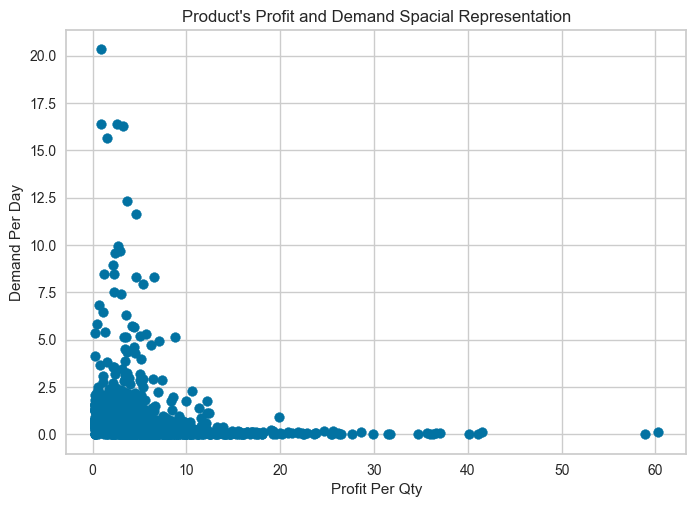

In [12]:
# Plotting the data

plt.scatter(cluster_ip_data.ProfitPerQty, cluster_ip_data.DemandPerDay)
plt.xlabel('Profit Per Qty')
plt.ylabel('Demand Per Day')
plt.title("Product's Profit and Demand Spacial Representation")
#plt.xlim(0, 10) 
#plt.ylim(0, 2.5)  


The values are spread out and are in different scale in each columns, hence they have to be Normalized.

## MinMax Normalizer

Min Max Normalizer has been implemented to align the scale of each columns:
$$\text{Min Max Scaler} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

,ProfitPerQty,DemandPerDay
count,1810.000000,1810.000000
mean,0.090538,0.026475
std,0.081519,0.067090
min,0.000000,0.000000
25%,0.049753,0.004051
50%,0.070220,0.009741
75%,0.105884,0.022124
max,1.000000,1.000000


Text(0.5, 1.0, "Product's Profit and Demand Spacial Representation")

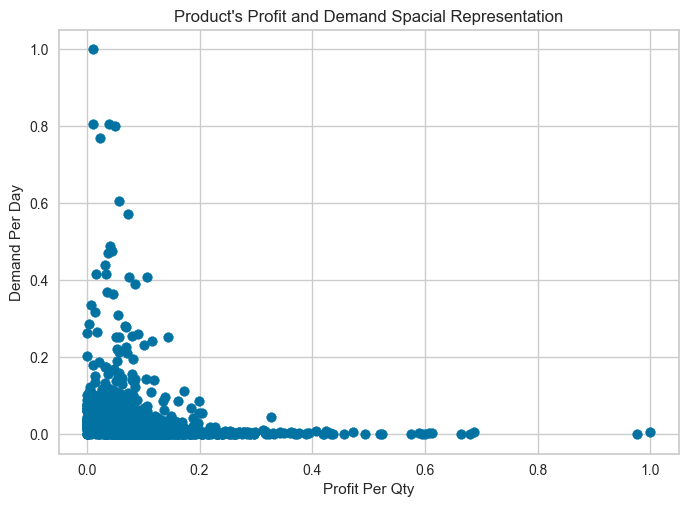

In [13]:
scaler = MinMaxScaler()
columns_to_normalize = ['ProfitPerQty', 'DemandPerDay']
cluster_ip_data[columns_to_normalize] = scaler.fit_transform(cluster_ip_data[columns_to_normalize])
display(cluster_ip_data.describe())

# Plotting the data

plt.scatter(cluster_ip_data.ProfitPerQty, cluster_ip_data.DemandPerDay)
plt.xlabel('Profit Per Qty')
plt.ylabel('Demand Per Day')
plt.title("Product's Profit and Demand Spacial Representation")


### Decide Ideal Number of Clusters

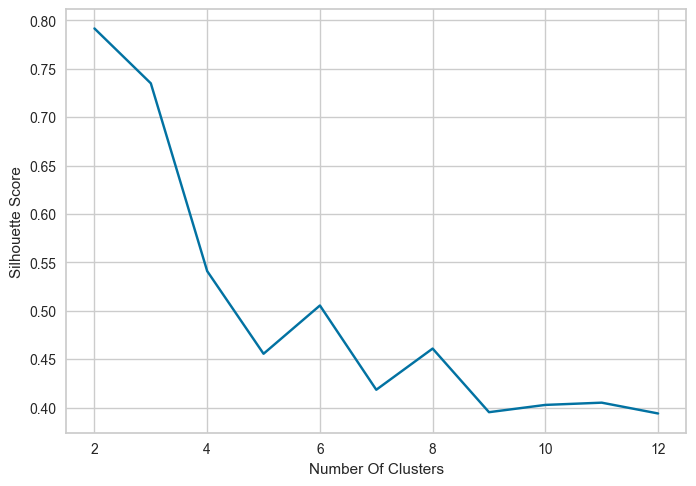

In [14]:
# Silhouette Score

silhouette= []
for i in range(2,13):
  cluster= KMeans(n_clusters=i, random_state=142).fit_predict(cluster_ip_data[['ProfitPerQty','DemandPerDay']])
  silhouette.append(metrics.silhouette_score(cluster_ip_data[['ProfitPerQty','DemandPerDay']], labels= cluster, metric= "euclidean"))

plt.plot(range(2,13),silhouette)
plt.xlabel("Number Of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

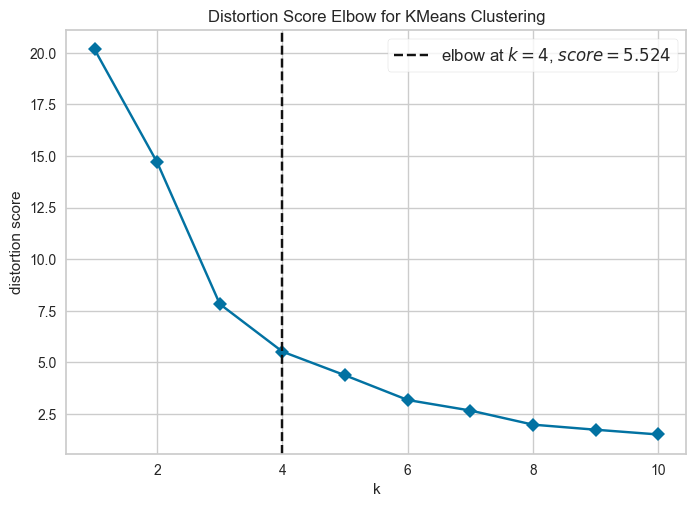

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Elbow Method

model = KMeans(random_state=142)
visualizer = KElbowVisualizer(model, k=(1,11), timings=False) # k is range of number of clusters.
visualizer.fit(cluster_ip_data[['ProfitPerQty','DemandPerDay']]) # Fit data to visualizer
visualizer.show()

4 clusters would be ideal according to the above Elbow curve

## Clustering

In [20]:
# Define the KMeans model with K=3
model= KMeans(n_clusters=3, random_state=142) 

# Fit the data and extract clusters
y_kmeans= model.fit_predict(cluster_ip_data[['ProfitPerQty','DemandPerDay']]) 
cluster_ip_data['cluster_number']= y_kmeans
df['cluster_number']= y_kmeans
display(df.cluster_number.value_counts().reset_index().rename(columns={'index':'Cluster Number', 'cluster_number':'Count'}))

# Creating interactive plot
cluster_colors = ['blue', 'green', 'red', 'yellow']


trace = go.Scatter(
    x=df.ProfitPerQty,
    y=df.DemandPerDay,
    mode='markers',
    marker=dict(
        color=df.cluster_number,
        colorscale=[[i / (len(cluster_colors) - 1), cluster_colors[i]] for i in range(len(cluster_colors))],  # Define custom discrete colorscale
        colorbar=dict(
            title='Cluster Number',
            tickvals=list(range(len(cluster_colors))),  # Set tick values for discrete clusters
            ticktext=['Cluster {}'.format(i) for i in range(len(cluster_colors))]  # Set tick labels for discrete clusters
        )
    )
)

# Create layout
layout = go.Layout(
    title="K-Means Clustering Output for K=3",
    xaxis=dict(title='Profit Per Qty ($)'),
    yaxis=dict(title='Demand Per Day'),
    margin=dict(l=10, r=0, t=50, b=0),
    plot_bgcolor='black',  # Set background color to black
    paper_bgcolor='black',  # Set paper color to black (the area outside the plot)
    font=dict(color='white'),  # Set text color to white
    xaxis_showgrid=False,  # Hide x-axis gridlines
    yaxis_showgrid=False  # Hide y-axis gridlines
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)
fig.show()
fig.write_html("kmeans_cluster_3.html")

,Cluster Number,Count
0,2,1658
1,0,117
2,1,35


In [23]:
# Define the KMeans model with K=3
model= KMeans(n_clusters=4, random_state=142) 

# Fit the data and extract clusters
y_kmeans= model.fit_predict(cluster_ip_data[['ProfitPerQty','DemandPerDay']]) 
cluster_ip_data['cluster_number']= y_kmeans
df['cluster_number']= y_kmeans
display(df.cluster_number.value_counts().reset_index().rename(columns={'index':'Cluster Number', 'cluster_number':'Count'}))

# Creating interactive plot
cluster_colors = ['blue', 'green', 'red', 'yellow']


trace = go.Scatter(
    x=df.ProfitPerQty,
    y=df.DemandPerDay,
    mode='markers',
    marker=dict(
        color=df.cluster_number,
        colorscale=[[i / (len(cluster_colors) - 1), cluster_colors[i]] for i in range(len(cluster_colors))],  # Define custom discrete colorscale
        colorbar=dict(
            title='Cluster Number',
            tickvals=list(range(len(cluster_colors))),  # Set tick values for discrete clusters
            ticktext=['Cluster {}'.format(i) for i in range(len(cluster_colors))]  # Set tick labels for discrete clusters
        )
    )
)

# Create layout
layout = go.Layout(
    title="K-Means Clustering Output for K=4",
    xaxis=dict(title='Profit Per Qty ($)'),
    yaxis=dict(title='Demand Per Day'),
    margin=dict(l=10, r=0, t=50, b=0),
    plot_bgcolor='black',  # Set background color to black
    paper_bgcolor='black',  # Set paper color to black (the area outside the plot)
    font=dict(color='white'),  # Set text color to white
    xaxis_showgrid=False,  # Hide x-axis gridlines
    yaxis_showgrid=False  # Hide y-axis gridlines
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)
fig.show()
fig.write_html("kmeans_cluster_4.html")

,Cluster Number,Count
0,2,1368
1,0,370
2,3,37
3,1,35


In [24]:
# Define the KMeans model with K=3
model= KMeans(n_clusters=5, random_state=142) 

# Fit the data and extract clusters
y_kmeans= model.fit_predict(cluster_ip_data[['ProfitPerQty','DemandPerDay']]) 
cluster_ip_data['cluster_number']= y_kmeans
df['cluster_number']= y_kmeans
display(df.cluster_number.value_counts().reset_index().rename(columns={'index':'Cluster Number', 'cluster_number':'Count'}))

# Creating interactive plot
cluster_colors = ['blue', 'green', 'red', 'yellow', 'grey']


trace = go.Scatter(
    x=df.ProfitPerQty,
    y=df.DemandPerDay,
    mode='markers',
    marker=dict(
        color=df.cluster_number,
        colorscale=[[i / (len(cluster_colors) - 1), cluster_colors[i]] for i in range(len(cluster_colors))],  # Define custom discrete colorscale
        colorbar=dict(
            title='Cluster Number',
            tickvals=list(range(len(cluster_colors))),  # Set tick values for discrete clusters
            ticktext=['Cluster {}'.format(i) for i in range(len(cluster_colors))]  # Set tick labels for discrete clusters
        )
    )
)

# Create layout
layout = go.Layout(
    title="K-Means Clustering Output for K=5",
    xaxis=dict(title='Profit Per Qty ($)'),
    yaxis=dict(title='Demand Per Day'),
    margin=dict(l=10, r=0, t=50, b=0),
    plot_bgcolor='black',  # Set background color to black
    paper_bgcolor='black',  # Set paper color to black (the area outside the plot)
    font=dict(color='white'),  # Set text color to white
    xaxis_showgrid=False,  # Hide x-axis gridlines
    yaxis_showgrid=False  # Hide y-axis gridlines
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)
fig.show()
fig.write_html("kmeans_cluster_5.html")

,Cluster Number,Count
0,2,1124
1,0,534
2,4,102
3,1,35
4,3,15


,Cluster Number,Count
0,2,1368
1,0,370
2,3,37
3,1,35


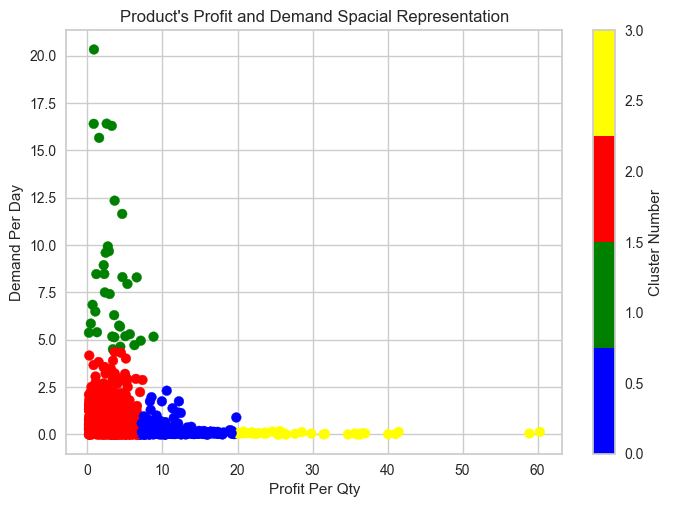

In [44]:
# Define the KMeans model
model= KMeans(n_clusters=4, random_state=142) 

# Fit the data and extract clusters
y_kmeans= model.fit_predict(cluster_ip_data[['ProfitPerQty','DemandPerDay']]) 
cluster_ip_data['cluster_number']= y_kmeans
df['cluster_number']= y_kmeans
display(df.cluster_number.value_counts().reset_index().rename(columns={'index':'Cluster Number', 'cluster_number':'Count'}))

# Plot the clusters
cluster_colors = ['blue', 'green', 'red', 'yellow']
plt.scatter(df.ProfitPerQty, df.DemandPerDay, c= df.cluster_number, cmap=ListedColormap(cluster_colors))
plt.xlabel('Profit Per Qty')
plt.ylabel('Demand Per Day')
plt.title("Product's Profit and Demand Spacial Representation")
plt.colorbar(label='Cluster Number')  
#plt.xlim(0, 10) 
#plt.ylim(0, 2.5)  

In [45]:
# Creating interactive plot
cluster_colors = ['blue', 'green', 'red', 'yellow']


trace = go.Scatter(
    x=df.ProfitPerQty,
    y=df.DemandPerDay,
    mode='markers',
    marker=dict(
        color=df.cluster_number,
        colorscale=[[i / (len(cluster_colors) - 1), cluster_colors[i]] for i in range(len(cluster_colors))],  # Define custom discrete colorscale
        colorbar=dict(
            title='Cluster Number',
            tickvals=list(range(len(cluster_colors))),  # Set tick values for discrete clusters
            ticktext=['Cluster {}'.format(i) for i in range(len(cluster_colors))]  # Set tick labels for discrete clusters
        )
    )
)

# Create layout
layout = go.Layout(
    title="Product's Profit and Demand Spacial Representation",
    xaxis=dict(title='Profit Per Qty ($)'),
    yaxis=dict(title='Demand Per Day'),
    margin=dict(l=10, r=0, t=50, b=0),
    plot_bgcolor='black',  # Set background color to black
    paper_bgcolor='black',  # Set paper color to black (the area outside the plot)
    font=dict(color='white'),  # Set text color to white
    xaxis_showgrid=False,  # Hide x-axis gridlines
    yaxis_showgrid=False  # Hide y-axis gridlines
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)
fig.show()

4 clusters have divided the data well and it has captured the extreme values in distinct clusters as required.

## Inference

In [46]:
grouped_df = df.groupby(['cluster_number']).agg({'ProfitPerQty': 'mean', 'DemandPerDay': 'mean'}).reset_index()
grouped_df['ProfitPerDay'] = grouped_df['ProfitPerQty'] * grouped_df['DemandPerDay']
grouped_df = grouped_df.round(2)
grouped_df.sort_values(by='ProfitPerDay', ascending= False)

,cluster_number,ProfitPerQty,DemandPerDay,ProfitPerDay
1,1,3.32,8.46,28.07
0,0,10.08,0.20,2.00
3,3,29.60,0.06,1.76
2,2,3.85,0.44,1.70


**Cluster 1: Cash Cow- High Demand Low Proift**

These are cash cow products that are very frequently purchased that yields lowest profit per product but yeilds the highest profit overall. These products generate consistent cash flow and are often considered as the main revenue drivers for a company. These products must have the highest inventory share.

**Cluster 0: Commodity- Low Demand Moderate Proift**

These are commodity products that are typically bought less but have moderate profit leading to a decent overall profit. These products must have moderate inventory share.

**Cluster 3: Luxury- Low Demand High Proift**

These are premium products that are rarely purchased but yields the hightest profit. These products must have the lowest inventory share.

**Cluster 2: Laggards- Low Demand Low Proift**

These products are laggards that have reasonable demand but low profits. These products usually takes up the inventory space and results in low overall profit. These products must have low inventory share. 




In [ ]:
df['ProductDemandCluster'] = df['cluster_number'].replace({0:'Commodity', 1:"Cash Cow", 2: "Laggard", 3:"Luxury"})
df['ProductDemandCluster'].drop(columns=['cluster_number'], inplace=True)

## Save the data for further use (ARM)


In [50]:
df.to_csv('Clustered_Product_Info.csv', index= False)